In [1]:
import os
import librosa, librosa.display
import IPython.display as ipd

BASE_FOLDER = "data/bitsocker"
forest_fruit_path = "bitsocker_def_forest_fruit_-Lindstedt_Music.wav"

forest_fruit, sr = librosa.load(os.path.join(BASE_FOLDER, forest_fruit_path))

In [2]:
print(forest_fruit[:10])

[ 7.5891614e-05 -2.0037591e-04  2.1684170e-04 -5.8948994e-04
  4.3743104e-04  4.7544390e-04  6.4626336e-05 -1.6181171e-04
 -9.8514371e-04 -1.2946501e-03]


# Basic Features


### Duration
Duration represents the length of the audio signal. It can be calculated by dividing the length of the samples with the sample rate

In [3]:
duration = len(forest_fruit) / sr
duration

111.62793650793651

In [4]:
duration = librosa.get_duration(y=forest_fruit, sr=sr)
print(f"Duration of the audio signal: {duration:.3f} seconds")

Duration of the audio signal: 111.628 seconds


### Sample Duration

In [5]:
sample_duration = 1 / sr # Inverse of sample rate
print(f"{sample_duration*100:.6f} ms") # Duration of 1 sample

0.004535 ms


### Amplitude Envelope (AE)
The amplitude envelope represents the varying amplitude of the audio signal over time. To extract this feature, we can use techniques such as peak detection or envelope following algorithms to capture the envelope of the signal.

- Max amplitude value of all samples in a frame
- Gives rough idea of loudness
- Sensitive to outliers
- Onset detection, music genre classification
    - Example: Understand when an acoustic event, such as a note, starts

$AE_t$, amplitude envelope at frame t

${\displaystyle AEt = \max_{k=t\cdot K}^{t+1\cdot K-1}} s(k)$

For each frame, take the highest value of the amplitude.

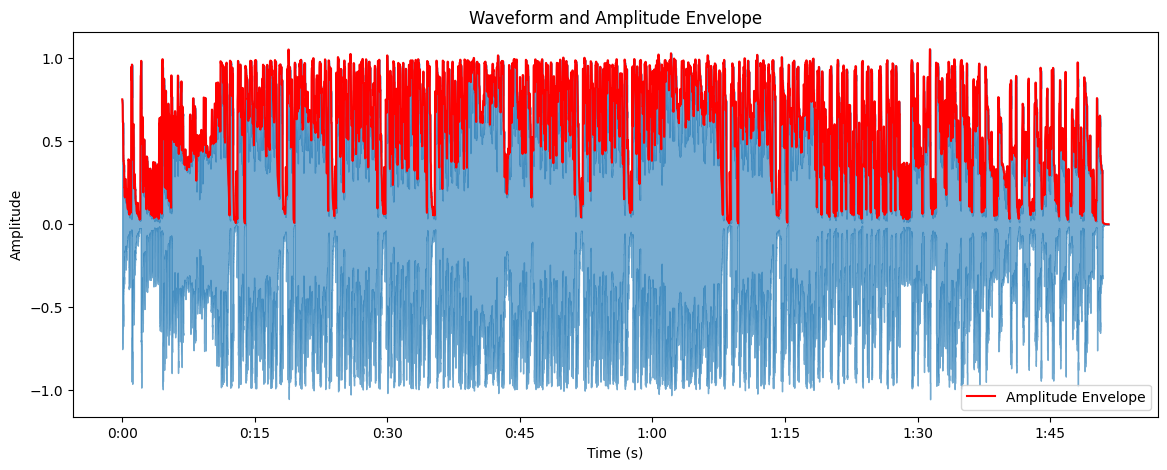

In [12]:
import numpy as np
import matplotlib.pyplot as plt
frame_size = 1024
hop_length = 512

# Pad the signal to ensure that we can calculate the last frame
y_padded = np.pad(forest_fruit, (0, frame_size), mode='constant')

# Calculate the maximum amplitude value for each frame
amplitude_envelope = [np.max(np.abs(y_padded[i:i+frame_size])) for i in range(0, len(forest_fruit), hop_length)]

# Convert frame indices to time
frames = range(len(amplitude_envelope))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(forest_fruit, sr=sr, alpha=0.6)
plt.plot(t, amplitude_envelope, color='r', label='Amplitude Envelope')
plt.title('Waveform and Amplitude Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### RMS Energy
RMS energy represents the root mean square amplitude of the audio signal. To extract this feature, we calculate the square root of the mean of the squared values of the signal samples.

- RMS of all samples in a frame
- Indicator of loudness
- Less sensitive to outliers than AE
- Audio segmentation, music genre classification

$RMS_t$, RMS at frame t

# $RMS_t = \sqrt{\frac{1}{K}\cdot\sum\limits_{k=t\cdot K}^{(t+1)\cdot K-1}s(k)^2} $



In [13]:
def rms(signal, frame_size, hop_length):
    rms = [] # contains rms for each frame

    for i in range(0, len(signal), hop_length):
        rms_current_frame = np.sqrt(np.sum(signal[i:i+frame_size]**2) / frame_size)
        rms.append(rms_current_frame)
    
    return np.array(rms)

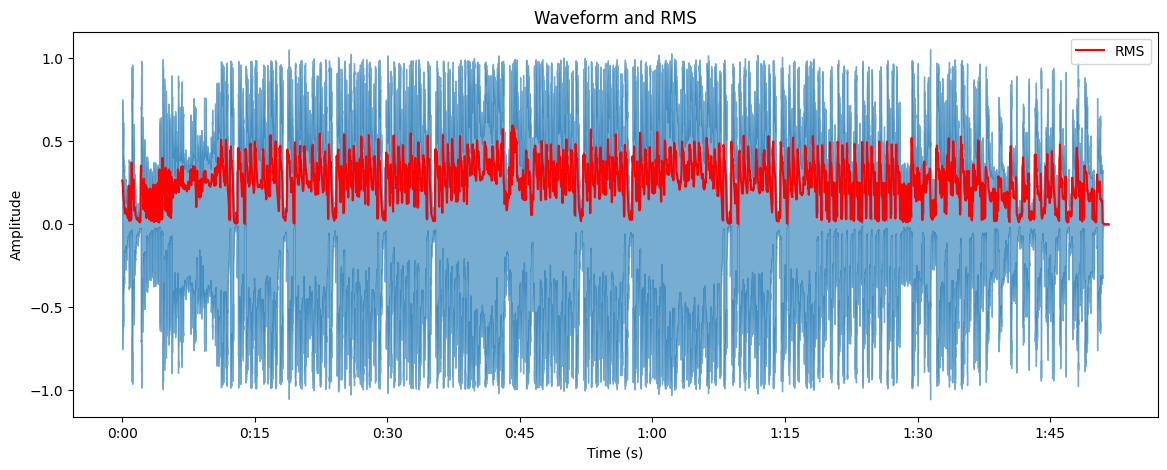

In [14]:
rms_values = rms(forest_fruit, frame_size, hop_length)

frames = range(len(rms_values))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(forest_fruit, sr=sr, alpha=0.6)
plt.plot(t, rms_values, color='r', label='RMS')
plt.title('Waveform and RMS')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Zero-crossing rate
Zero crossing rate is the rate at which the audio signal changes sign. To extract this feature, we count the number of times the signal changes sign and divide it by the duration of the signal.

- Number of times a signal crosses the horizontal axis
- Recoginition of percussive vs pitches sound
- Monophonic pitch estimation
- Voice/unvoiced decision for speech signal

$ZCR_t$

# $ZCR_t = \frac{1}{2}\cdot \sum\limits_{k=t\cdot K}^{t+1\cdot K-1} | sgn(s(k)) - sgn(s(k+1)) |$

Sign function:
- s(k) > 0 -> +1
- s(k) < 0 -> -1
- s(k) = 0 -> 0

In [15]:
zcr_values = librosa.feature.zero_crossing_rate(y=forest_fruit, frame_length=frame_size, hop_length=hop_length)[0]

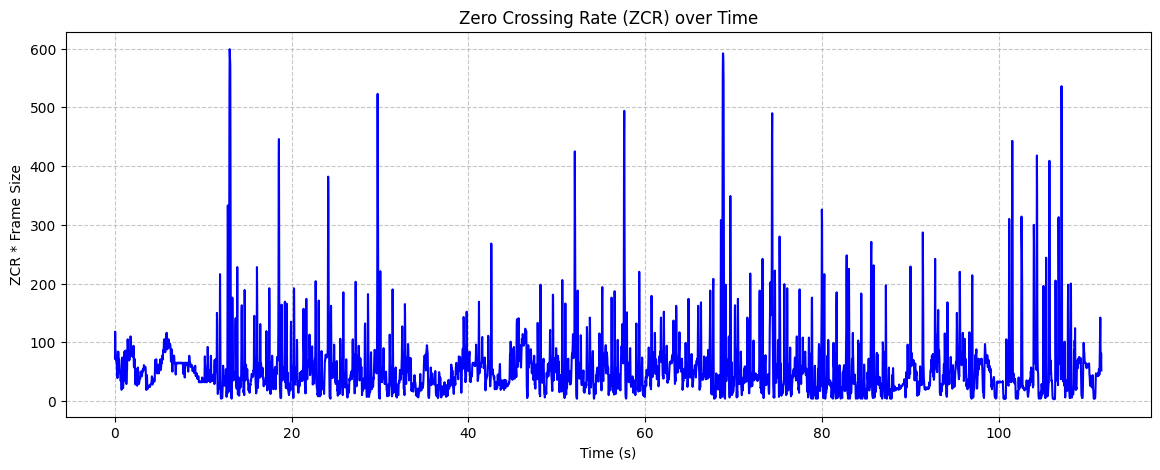

In [16]:
plt.figure(figsize=(14, 5))
plt.plot(t, zcr_values * frame_size, color='b', linewidth=1.5)  # multiply by frame length to avoid normalization
plt.title('Zero Crossing Rate (ZCR) over Time')
plt.xlabel('Time (s)')
plt.ylabel('ZCR * Frame Size')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Spectrogram
A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. To extract a spectrogram, we use Short-Time Fourier Transform (STFT) to compute the frequency spectrum over short, overlapping time windows.

In [18]:
D = librosa.stft(forest_fruit, n_fft=frame_size, hop_length=hop_length)
print(D.shape) # frequency bins & frames
print(type(D[0][0]))

(513, 4808)
<class 'numpy.complex64'>


In [19]:
D = np.abs(D) ** 2
print(type(D[0][0]))

<class 'numpy.float32'>


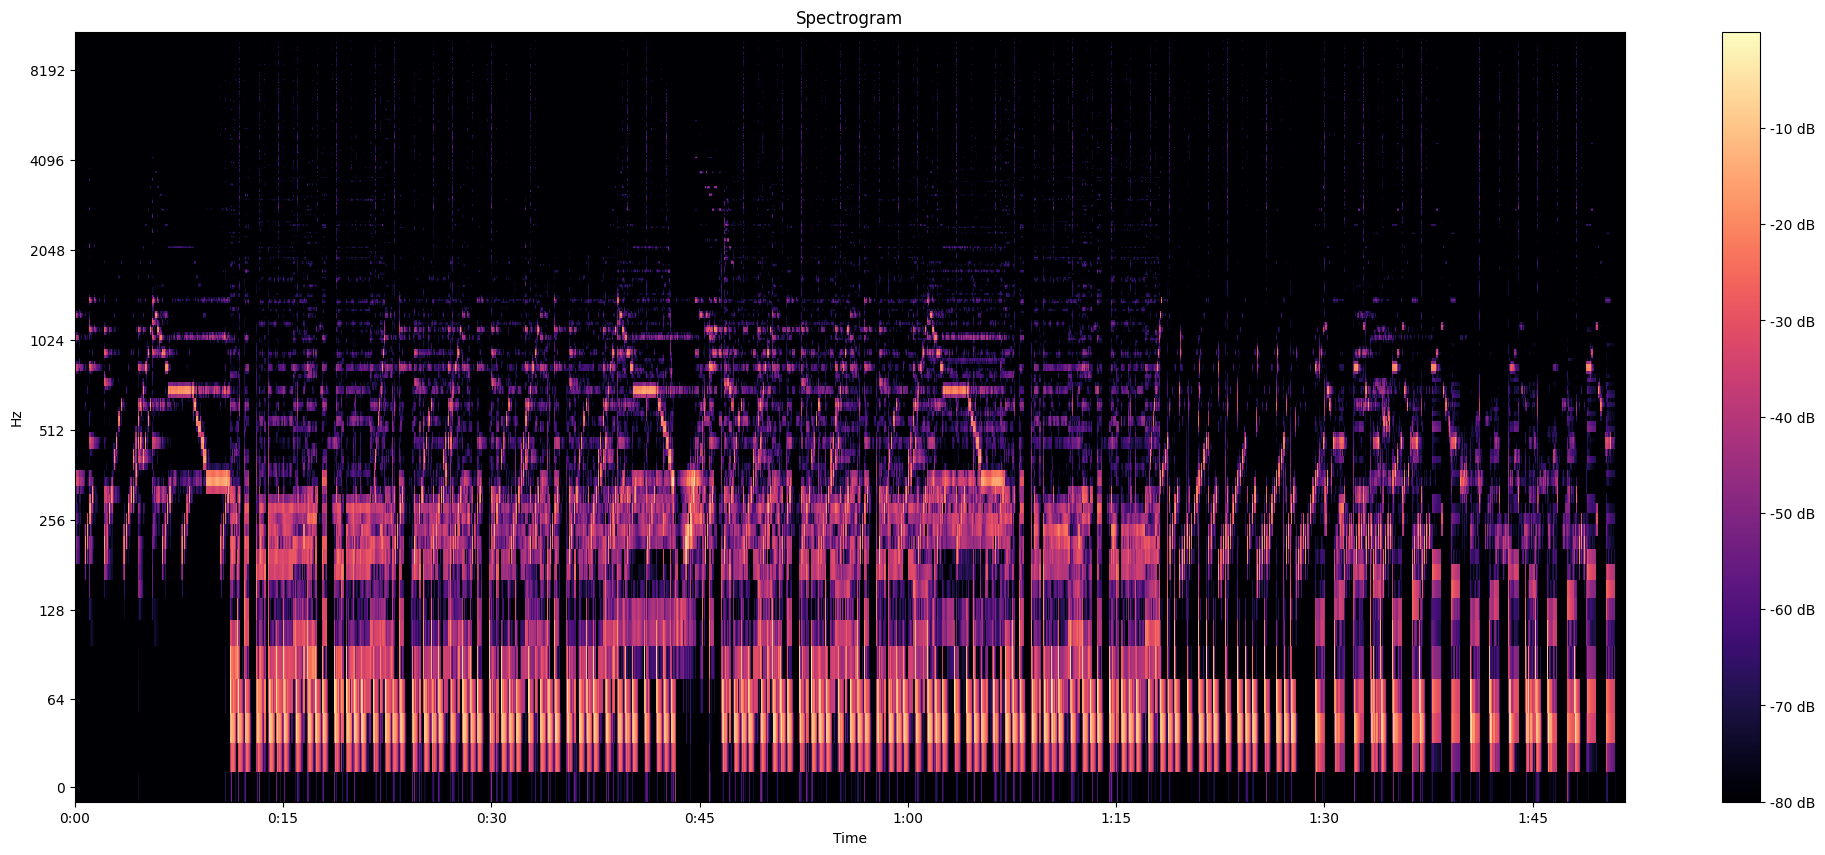

In [21]:
def plot_spectrogram(Y, sr, hop_length, y_axis="log"):
    plt.figure(figsize=(25,10))
    librosa.display.specshow(librosa.amplitude_to_db(Y, ref=np.max), sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')


plot_spectrogram(D, sr, hop_length)

### Spectral Bandwidth
Spectral bandwidth describes the spread of frequencies around the spectral centroid. It can be calculated using various methods, such as the standard deviation of the frequency distribution.

In librosa documentation and examples, D is often used as a variable name to represent the magnitude spectrogram returned by the Short-Time Fourier Transform (STFT) function (librosa.stft). The letter "D" may stand for "data" or "magnitude" as it contains the magnitude information of the signal across time and frequency bins.

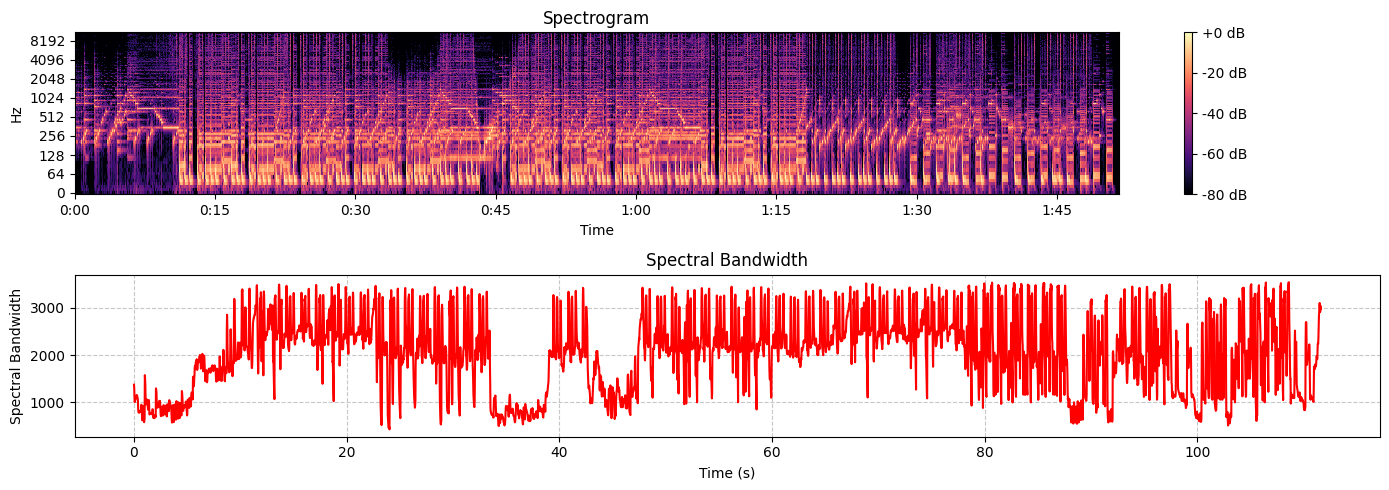

In [22]:
D = np.abs(librosa.stft(forest_fruit))

spectral_centroid = librosa.feature.spectral_centroid(S=D)

spectral_bandwidth = librosa.feature.spectral_bandwidth(S=D, centroid=spectral_centroid)

frames = range(len(spectral_centroid[0]))
t = librosa.frames_to_time(frames)


plt.figure(figsize=(14, 5))

plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

plt.subplot(2, 1, 2)
plt.plot(t, spectral_bandwidth[0], color='r')
plt.title('Spectral Bandwidth')
plt.xlabel('Time (s)')
plt.ylabel('Spectral Bandwidth')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Spectral Centroid
Spectral centroid indicates where the "center of mass" of the spectrum is located. To extract this feature, we calculate the weighted mean of the frequencies present in the signal, where the weights are the magnitudes of the corresponding spectral components.

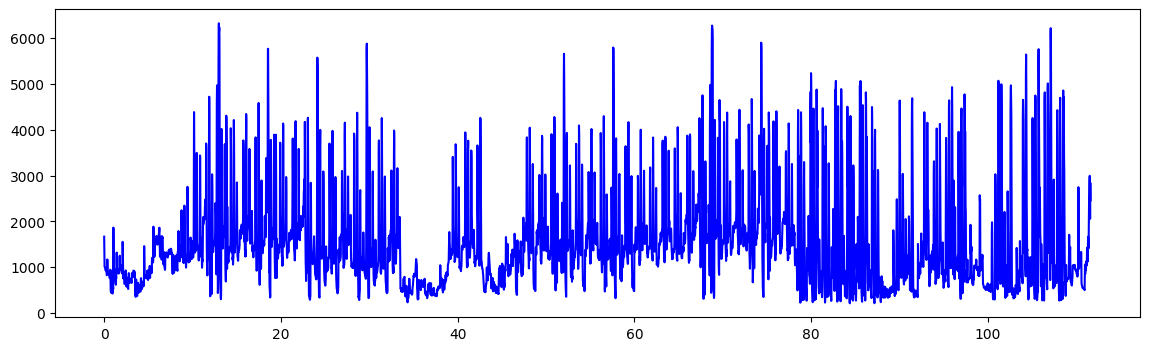

In [24]:
sc_values = librosa.feature.spectral_centroid(y=forest_fruit, sr=sr, n_fft=frame_size, hop_length=hop_length)[0]

frames = range(len(sc_values))
t = librosa.frames_to_time(frames)

plt.figure(figsize=(14,4))
plt.plot(t, sc_values, color='b')
plt.show()

### Mel-spectrogram

The way we percieve pitch is not linear, but rather logarithmical.

An ideal audio feature is a time-frequency representation with perceptually relevand amplitude and frequency representaion.

Mel spectrograms are related to the mel scale, which is a perceptual scale for pitch.

It's a logarithmic scale where 1000 Hz = 1000 Mel.

$ m = 2595 \cdot log(1+\frac{f}{500})$

$ f = 700(10^{m \ 2696}-1)$

- Extract STFT
- Convert amplitude to DBs
- Convert freq to Mel scale


1. Chose a number of mel bands
2. Construct mel filter banks
3. Apply mel filter banks to spectrogram

### Chose a number of mel bands
Number of mel bands is a very fundamental parameter which can vary. 40, 60, 90. 128? Sure! It depends on the problem.

It's the same as asking what learning rate to use, so in a way its a hyper parameter.

The idea of a mel band is like a range of relevat frequencies.

### Construct mel filter banks

$ m = 2595 \cdot log(1+\frac{f}{500})$

1. Convert lowest/highest freq to Mel
2. Create n bands equally spaced points as the number of mel bands we want to use
    - Mel points are the centers of the mel bands
3. Converting the points back to Hertz ($ f = 700(10^{m \ 2696}-1)$)
4. Round to nearest frequency bin
    - Discrete signals, we don't have perfect resolution which is constrained by FT frame size
5. Create triangular filters ´
    - Building blocks of mel filter banks

![alt text](assets/img/mel_filter_bank.png)

Spread out the frequencies to get the same perception.

To construct a single triangular filter for one mel band, the center for the second mel band is 1526, the lower end and higher ends are the centers of the previous and next melbands.

### Mel filter bank's shape
M = (n bands, framesize / 2 + 1)

Y = (framesize / 2 + 1, n frames)

Number of columns in M is equal to the number of rows in Y.

This means we can apply matrix multiplication.

Mel spectrogram = MY




In [25]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)

In [26]:
filter_banks.shape

(10, 1025)

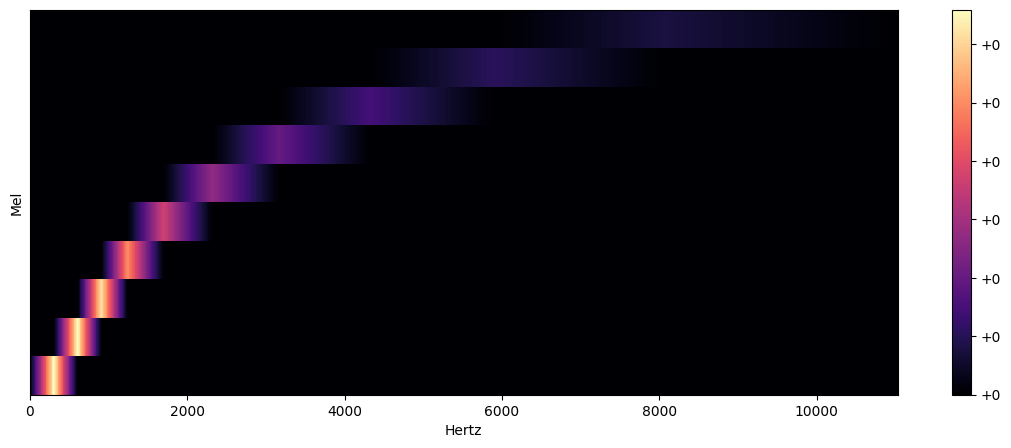

In [27]:
plt.figure(figsize=(14,5))
librosa.display.specshow(filter_banks, sr=sr, x_axis="linear")
plt.xlabel("Hertz")
plt.ylabel("Mel")
plt.colorbar(format="%+2.f")
plt.show()

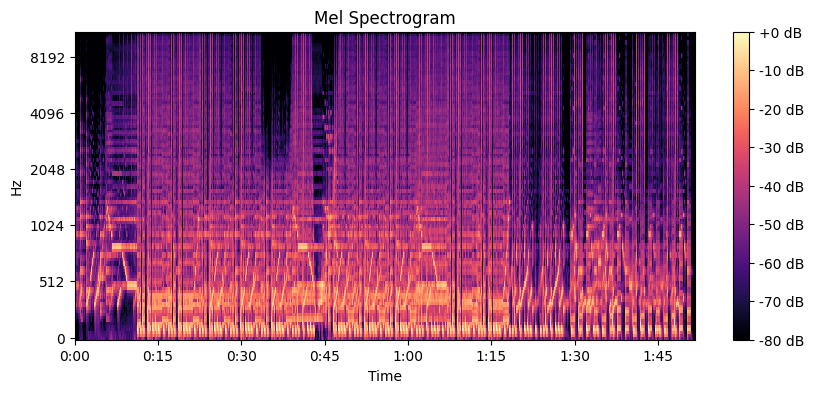

In [28]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def hz_to_mel(f):
    return 2595 * np.log10(1 + f / 700)

def mel_to_hz(m):
    return 700 * (10**(m / 2595) - 1)

def construct_mel_filter_bank(n_fft, sr, n_mels=128):
    # Convert Hz to Mel scale for lowest and highest frequency
    mel_low = hz_to_mel(0)
    mel_high = hz_to_mel(sr / 2)
    
    # Equally spaced points along the Mel scale
    mel_points = np.linspace(mel_low, mel_high, num=n_mels + 2)
    
    # Convert Mel scale points back to Hz
    freq_points = mel_to_hz(mel_points)
    
    # Round to the nearest frequency bin
    bin_points = np.floor((n_fft + 1) * freq_points / sr).astype(int)
    
    # Construct triangular filter banks
    filter_bank = np.zeros((n_mels, n_fft // 2 + 1))
    for i in range(1, n_mels + 1):
        filter_bank[i - 1, bin_points[i - 1]:bin_points[i]] = (bin_points[i] - bin_points[i - 1]) - \
                                                              np.arange(bin_points[i] - bin_points[i - 1])
        filter_bank[i - 1, bin_points[i]:bin_points[i + 1]] = (bin_points[i + 1] - bin_points[i]) - \
                                                              np.arange(bin_points[i + 1] - bin_points[i])
    
    return filter_bank / np.maximum(np.sum(filter_bank, axis=1, keepdims=True), np.finfo(float).eps)


n_fft = 2048
hop_length = 512
stft = librosa.stft(forest_fruit, n_fft=n_fft, hop_length=hop_length)

magnitude_spectrogram = np.abs(stft)

magnitude_spectrogram_db = librosa.amplitude_to_db(magnitude_spectrogram)

mel_filter_bank = construct_mel_filter_bank(n_fft, sr, 128)

mel_spectrogram = np.dot(mel_filter_bank, magnitude_spectrogram)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(mel_spectrogram, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


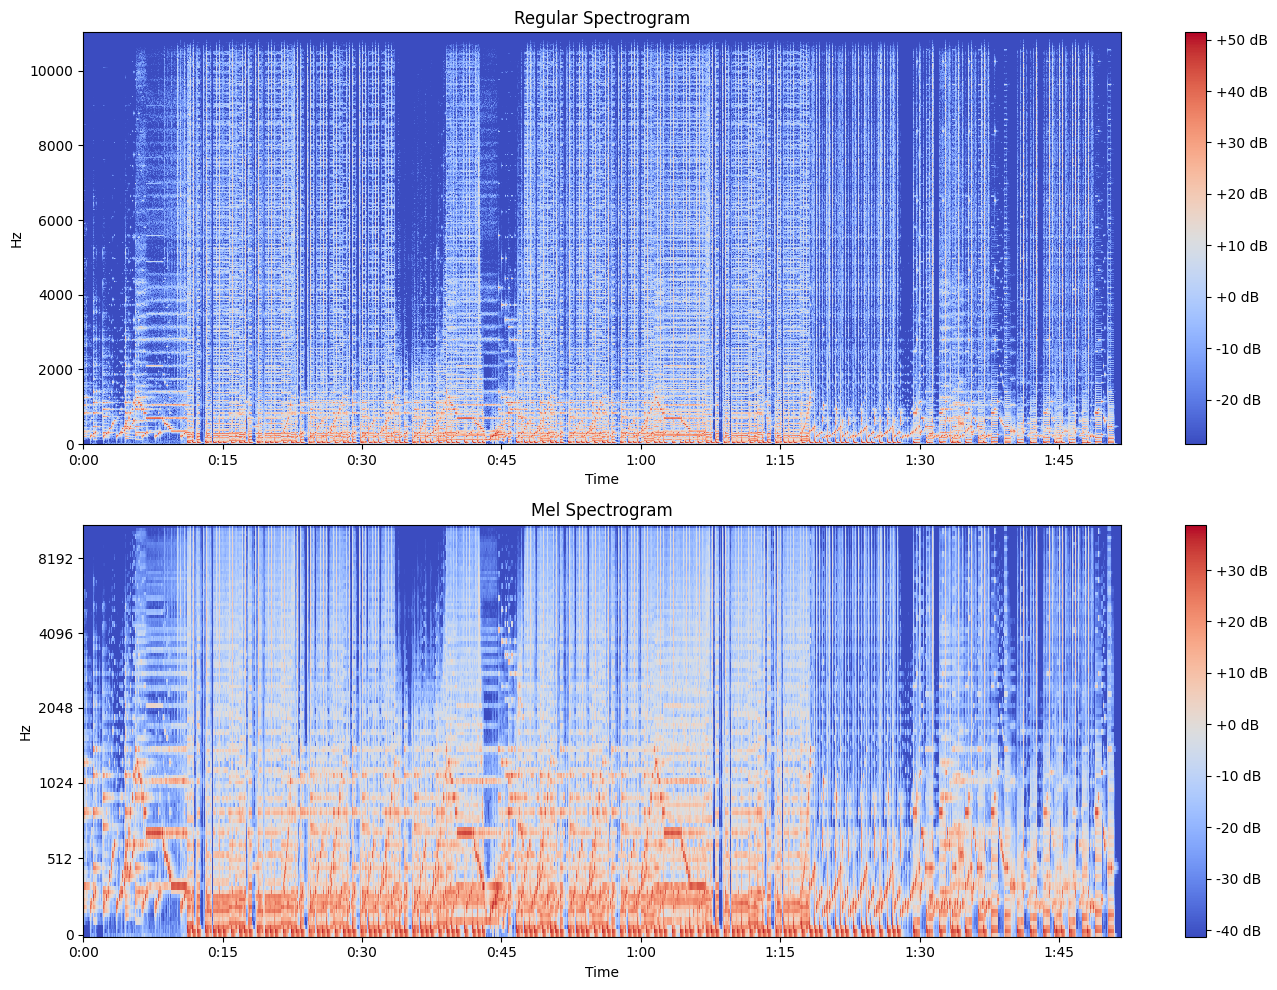

In [29]:
# STFT parameters
n_fft = 2048
hop_length = 512

# Regular spectrogram
spectrogram = np.abs(librosa.stft(forest_fruit, n_fft=n_fft, hop_length=hop_length))

spectrogram_db = librosa.amplitude_to_db(spectrogram)

# Mel bands
n_mels = 128

filter_banks = librosa.filters.mel(n_fft=n_fft, sr=sr, n_mels=n_mels) # Mel filter banks

mel_spectrogram = librosa.feature.melspectrogram(y=forest_fruit, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

mel_spectrogram_db = librosa.power_to_db(mel_spectrogram)

plt.figure(figsize=(14, 10))

# Spectrogram
plt.subplot(2, 1, 1)
librosa.display.specshow(spectrogram_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Regular Spectrogram')

# Mel Spectrogram
plt.subplot(2, 1, 2)
librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

plt.tight_layout()
plt.show()

### Mel-Frequency Cepstral Coefficients (MFCCs)
MFCCs represent the short-term power spectrum of a sound, mimicking the human ear's response to sound. To extract MFCCs, we take the Discrete Cosine Transform (DCT) of the log-magnitude Mel-spectrum.

# Raw waveforms into MFCC (Mel-Frequency Cepstral Coefficients)

-> Short-Time Fourier Transform

If we just do FFT, we will just change the time to be frequency and the magnitude of the frequencies.
Basically expanding signal in terms of sines and cosines.

We want to keep both the time and the frequency. To do that, we want STFT (Short-Time Fourier Transform)

x -> signal in the time domain:

$ x \in \mathbb{R}^{28200 = 3.525 seconds \times 8000 hz}$

Think of the signal in the time domain as a long vector.

8000 samples represents the signal / second, so in total 28 200 dimensions for x.

g -> sliding window function (e.g. Hammering function) (more on this later)

![alt text](assets/img/sliding_window.png))

[Gao, Robert X. Ruqiang Yan "Non stationary signal processing for bearing health monitoring." International journal of manufacturing research 1.1 (2006): 18-40](https://www.researchgate.net/publication/220650705_Non-stationary_signal_processing_for_bearing_health_monitoring)

$ X_i \in \mathbb{R}^{200} $ -> i:th frame of signal x (25 ms frames)

80 -> frame step (10 ms) -> $X \in \mathbb{R}^{200 \times 350} (350=28,200-200)/80) $

$\bar{X}_{i} \in \mathbb{C}^{k}$ -> Discrete fourier tranform of $X{i}$ -> $\bar{X} \in \mathbb{C}^{K \times 350}$

The Discrete Fourier Transform

$\bar{X_i}(k) = \sum\limits_{n=1}^{N}{x_{i}(n)g(n)e^{-j2\pi kn/N}},k = 1, ..., K$

n is the size of the signal per each frame

N = 200

K = 257 -> Number of discrete fourier transform coefficients 

Because we don't like working with complex numbers, we're going to take tha absolute values of the complex numbers

$P_{i}(k) = \frac{1}{N}|\bar{X}_{i}(k)|^2$ -> Periodogram esitmate of the power spectrum

-> $P \in \mathbb{R}^{257 \times 350}$

Mel-spaced Filterbank
300 Hz -> lower frequency
4000 Hz -> upper frequency

$M(f) = 1,25 ln(1+ f/700)$ -> convert frequency to Mel scale

$M^{-1}(m)=700(exp(m/1,125)-1)$ -> Convert Mel scale to Hz

$M^{-1}(linspace(M(300),M(4,000),26+2))$ Linear 

26 triangular (linear) filters that we can put in a matrix

(26 triangles x 257)

-> $E = TP \in \mathbb{R}^{26 \times 350}$

$E_{i}(l)$ -> amount of energy in filter bank l at frame i

$log(E) \in \mathbb{R}^{26 \times 350}$ -> log filter bank energy

If we take the log, we will get a **log** Mel spectrogram, this is what the neural network will see.

This is for Deep learning.

One extra last step:

We could get MFCC Coefficients from Discrete Cosine Transform (DCT) (getting rid of the sines)

We lose *some* information by performing DCT to get MFCC Coefficients.


In [30]:
mfccs = librosa.feature.mfcc(y=forest_fruit, n_mfcc=13, sr=sr)

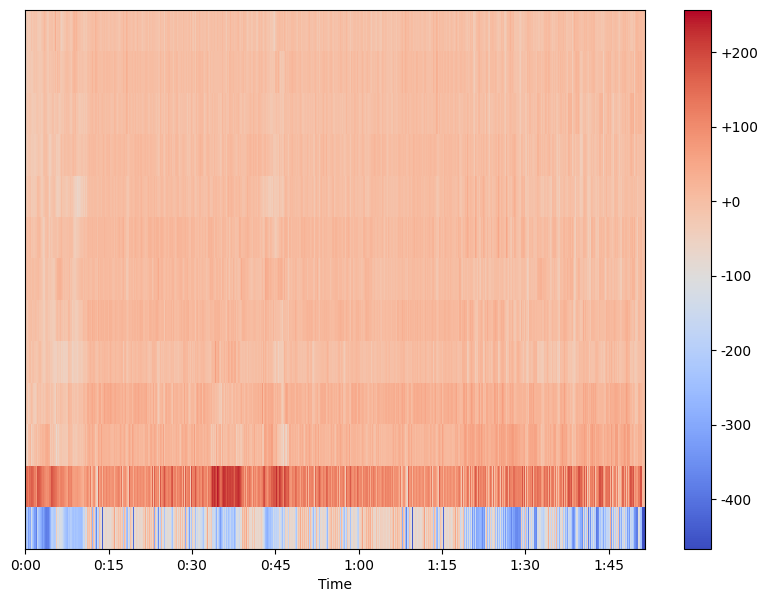

In [31]:
plt.figure(figsize=(10, 7))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [32]:
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

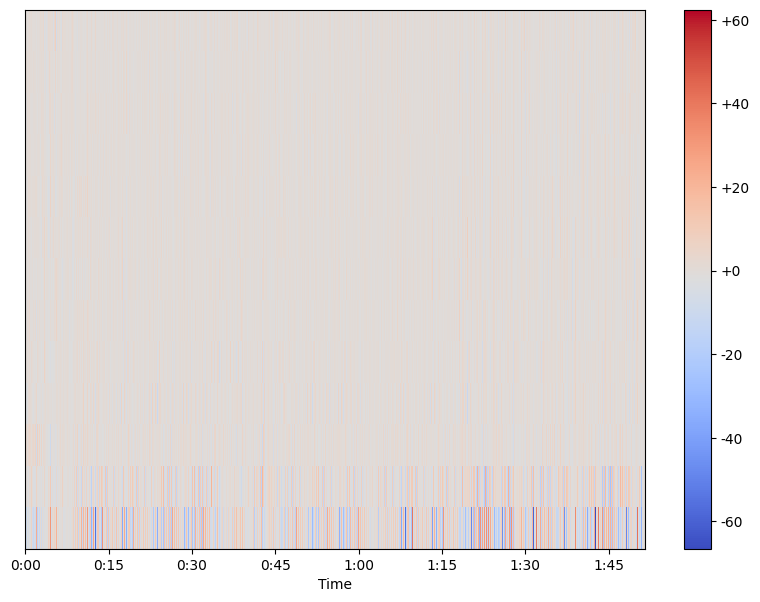

In [33]:
plt.figure(figsize=(10, 7))
librosa.display.specshow(delta_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

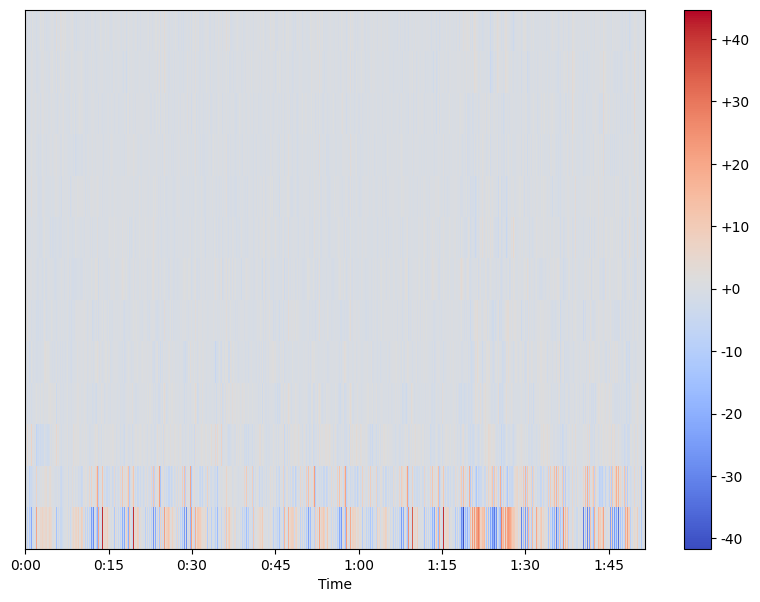

In [34]:
plt.figure(figsize=(10, 7))
librosa.display.specshow(delta2_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

# Advanced Features


### Cepstral Mean Normalization (CMN)
CMN is a technique used to normalize MFCC features by subtracting the mean cepstral vector across all frames. This helps in reducing channel variations and improving speech recognition accuracy.

### Perceptual Linear Prediction (PLP) Coefficients
PLP coefficients are similar to MFCCs but are computed using a different filterbank design that better represents the human auditory system's perceptual characteristics.

### Harmonic-Percussive Source Separation
This technique separates an audio signal into harmonic and percussive components, allowing for individual processing of different sound components.

### Spectral Contrast
Spectral contrast measures the difference in magnitude between peaks and valleys in the spectrum, providing information about timbral texture. It can be computed by comparing the energy in different frequency bands.

### Spectral Roll-off
Spectral roll-off is the frequency below which a certain percentage of the total spectral energy lies. It is often used to characterize the brightness of a sound.

### Temporal Envelope
Temporal envelope represents the variation of energy in the signal over time, providing information about the dynamics of the audio. It can be extracted using techniques like Hilbert transform or envelope following algorithms.

### Harmonic-to-Noise Ratio (HNR)
HNR measures the ratio of harmonic to noise components in the signal, providing information about the clarity of the harmonic structure. It can be computed by comparing energy in harmonic and non-harmonic regions of the spectrum.

### Pitch Strength
Pitch strength measures the likelihood of the presence of a pitch at a given time, providing information about the pitch salience in the signal. It can be computed using techniques such as autocorrelation or spectral correlation.

### Fundamental Frequency (F0) Estimation
F0 estimation involves estimating the fundamental frequency of the signal, which corresponds to the perceived pitch. Various algorithms, such as autocorrelation, cepstral analysis, or spectral analysis, can be used for F0 estimation.

### Mel-Frequency Discrete Wavelet Coefficients (MFDWC)
MFDWCs are similar to MFCCs but are computed using a wavelet transform instead of a Fourier transform, providing a different representation of the spectral content of the signal.

### Modulation Spectrogram
Modulation spectrogram represents the variation of spectral content over time and modulation frequencies, providing information about the temporal structure and rhythmic patterns in the signal.

### Sub-band Energy Ratio (SBER)
SBER measures the ratio of energy in different frequency sub-bands, providing information about the spectral shape and tonal balance of the signal. It can be computed by dividing the energy in each sub-band by the total energy in the signal.

### Spectral Flatness Measure
Spectral flatness measure quantifies the flatness of the spectrum, indicating the degree of tonalness versus noisiness in the signal. It can be computed as the ratio of the geometric mean to the arithmetic mean of the power spectrum.

### Non-linear Energy Operator (NEO)
NEO is a time-domain feature extraction method that measures the energy distribution in the signal using non-linear operations, providing information about the signal's dynamics and transient characteristics.


# Deep Learning Features

### Convolutional Neural Network (CNN) Features
CNN features are learned representations extracted from audio spectrograms using convolutional layers. These layers apply filters across the spectrogram to capture local patterns in the frequency and time domain, encoding features such as pitch, timbre, and texture. CNNs are particularly effective for tasks requiring spatial hierarchy and translation invariance, such as audio classification and localization.

### Recurrent Neural Network (RNN) Features
RNN features are learned representations extracted from sequential audio data, capturing temporal dependencies and dynamics in the signal. Architectures like Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) enable RNNs to model long-range dependencies and handle varying-length input sequences. RNNs excel in tasks requiring memory and sequential processing, such as speech recognition, language modeling, and music generation.

### Attention Mechanisms
Attention mechanisms are used to selectively focus on relevant parts of the audio signal while processing, improving model performance by dynamically weighting different input features based on their importance. They enable models to attend to specific time-frequency regions in the spectrogram or sequential audio data, enhancing interpretability and performance in tasks such as speech recognition, speaker diarization, and music transcription.

### Transformer-Based Models
Transformer-based models, such as the Transformer architecture and its variants (e.g., BERT, GPT), are used for sequence-to-sequence tasks in audio processing. By leveraging self-attention mechanisms, transformers enable efficient processing of long-range dependencies and capture complex contextual information in the audio signal. They excel in tasks like speech synthesis, language translation, and music generation, where capturing global context is crucial.

### Deep Audio Embeddings
Deep audio embeddings are high-dimensional representations learned by deep neural networks, capturing semantic information and similarities between audio samples in a continuous vector space. These embeddings are obtained by training models to map raw audio waveforms or spectrograms to a fixed-size embedding space, enabling tasks such as audio retrieval, similarity search, and clustering.

### Siamese Networks
Siamese networks are used for tasks such as audio similarity and verification. They learn to map pairs of input audio samples to a common feature space, where similar samples are closer together and dissimilar samples are farther apart. Siamese networks are trained with contrastive or triplet loss functions, enabling applications like speaker verification, voice conversion, and audio matching.

### Autoencoders
Autoencoders are used for unsupervised representation learning, training to reconstruct the input audio signal from a compressed latent representation. By learning to compress and decompress the input signal, autoencoders capture salient features and reduce dimensionality, enabling tasks such as denoising, source separation, and anomaly detection in audio data.

### Graph Neural Networks (GNNs)
GNNs are used for structured audio data, such as audio graphs representing relationships between audio samples or acoustic events. By modeling interactions and dependencies between nodes in the graph, GNNs capture complex relationships and enable tasks such as event detection, sound event localization, and acoustic scene analysis.

### Capsule Networks
Capsule networks are used for learning hierarchical representations of audio features, capturing part-whole relationships and enabling robustness to variations in viewpoint and scale. By encoding spatial hierarchies and pose information, capsule networks excel in tasks like speaker recognition, emotion detection, and sound event classification, where capturing fine-grained details is crucial.

### Transfer Learning
Transfer learning involves leveraging pre-trained deep learning models on large-scale audio datasets, fine-tuning them on specific tasks or domains with limited labeled data. By transferring knowledge from pre-trained models, transfer learning improves generalization and performance in tasks such as speech recognition, audio classification, and sound event detection, especially in data-scarce scenarios.

### Data Augmentation Techniques
Data augmentation techniques such as time stretching, pitch shifting, noise injection, and spectrogram augmentation are used to increase the diversity of training data and improve the robustness and generalization of deep learning models. By introducing variations in the training data, data augmentation enhances model performance and reduces overfitting, enabling better performance in real-world audio scenarios.

### Generative Adversarial Networks (GANs)
GANs are used for audio generation and enhancement tasks, learning to generate realistic audio samples or to improve the quality of noisy or degraded audio signals through adversarial training. By training a generator to produce realistic audio and a discriminator to distinguish between real and generated audio, GANs enable applications like speech synthesis, voice conversion, and audio denoising, achieving state-of-the-art results in audio generation and enhancement.
